## What has our model learnt?

Measuring accuracy is not enough!

Does the model make decisions based on reasonable evidence?

In [1]:
import random as rn
rn.seed(1254)

import numpy as np
np.random.seed(1515)
np.set_printoptions(precision=2)

import h5py
import pickle

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import librosa, librosa.display

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

import tensorflow as tf
tf.set_random_seed(2)

# block multithreading for the sake of reproducible results
config = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1 
)

# dynamically grow the memory used on the GPU 
config.gpu_options.allow_growth = True  
sess = tf.Session(graph= tf.get_default_graph(), config=config) 
    
import keras 
from keras import backend as K
from keras.models import load_model
K.set_learning_phase(1)

Using TensorFlow backend.


In [2]:
plt.rcParams['figure.figsize'] = (14, 8)

In [3]:
workspace = '/home/speakers/isobieraj/workspace'

modelpath = os.path.join(workspace,'models','crnn_epoch_014_val_loss_1.4415.hdf5')
hdf5_path = os.path.join(workspace,'dataset.hdf5')

In [4]:
# LOAD DATA
hf = h5py.File(hdf5_path, 'r')
X_train = np.array(hf.get('X_train') )
y_train = np.array(hf.get('y_train'))
X_val =  np.array(hf.get('X_val'))
y_val= np.array(hf.get('y_val'))
X_test = np.array(hf.get('X_test'))
y_test = np.array(hf.get('y_test'))
y_label = np.array(hf.get('y_label'))

n_features= hf.get('n_features').value
n_frames=hf.get('max_length_samp').value
label_list= hf.get('label_list').value

In [5]:
model=load_model(modelpath)

In [6]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
layer_dict.keys()

dict_keys(['input_1', 'conv2d_1', 'max_pooling2d_1', 'batch_normalization_1', 'dropout_1', 'conv2d_2', 'max_pooling2d_2', 'batch_normalization_2', 'dropout_2', 'conv2d_3', 'max_pooling2d_3', 'batch_normalization_3', 'time_distributed_1', 'dropout_3', 'lstm_1', 'dropout_4', 'dense_1'])

#### What did the filters learn? 

+ Which input activates the filters the most?

In [7]:
# choose the layer to visualise
layer_name = 'conv2d_1'

# get the dimensions of the input
input_data = model.input

In [8]:
# choose which filters to visualise
filter_index = range(10,30)

gen_im_conv2d_1=[]

# define the output to be maximalised
layer_output = layer_dict[layer_name].output

for f in filter_index:
    # define a cost function to maximise 
    cost = K.mean(layer_output[:, :, :, f],)
    
    grads = 0
    # compute the gradient of the input picture wrt this cost
    grads = K.gradients(cost, input_data)[0]

    # normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # this function returns the cost and grads given the input matrix
    iterate = K.function([input_data], [cost, grads])
    
    input_data_gen = np.random.random((1, n_frames, n_features, 1))
    for i in range(10):
        loss_value, grads_value = iterate([input_data_gen])
        input_data_gen += grads_value 
        
        if loss_value <= 0.:
           # some filters get stuck to 0, we can skip them
            break
    gen_im_conv2d_1.append(input_data_gen)

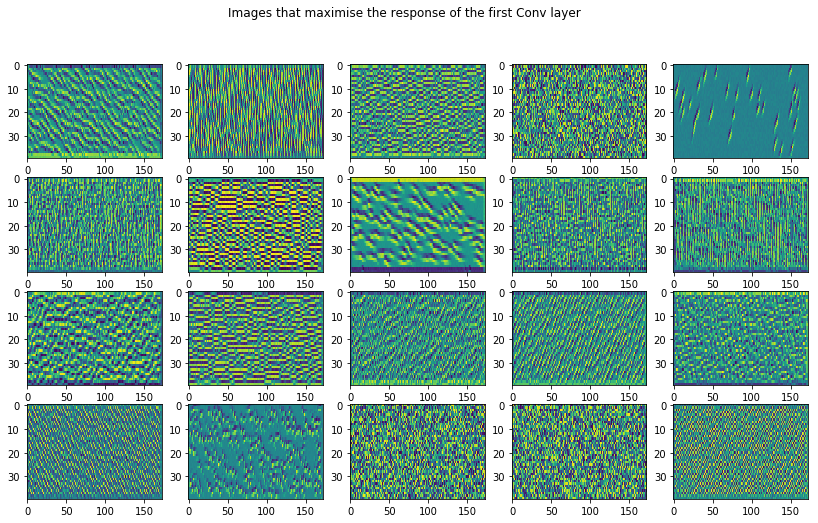

In [9]:
fig = plt.figure()
plt.suptitle('Images that maximise the response of the first Conv layer')
for idx, im in enumerate(gen_im_conv2d_1): 
    plt.subplot(4,5,idx+1)
    plt.imshow(im[0,:,:,0].T, aspect='auto')

In [10]:
# choose the layer to visualise
layer_name = 'conv2d_2'

In [11]:
# choose which filters to visualise
filter_index = range(10,30)

gen_im_conv2d_2=[]

# define the output to be maximalised
layer_output = layer_dict[layer_name].output

for f in filter_index:
    # define a cost function to maximise 
    cost = K.mean(layer_output[:, :, :, f],)
    
    grads = 0
    # compute the gradient of the input picture wrt this cost
    grads = K.gradients(cost, input_data)[0]

    # normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # this function returns the cost and grads given the input matrix
    iterate = K.function([input_data], [cost, grads])
    
    input_data_gen = np.random.random((1, n_frames, n_features, 1))
    for i in range(10):
        loss_value, grads_value = iterate([input_data_gen])
        input_data_gen += grads_value 
        
        if loss_value <= 0.:
           # some filters get stuck to 0, we can skip them
            break
    gen_im_conv2d_2.append(input_data_gen)

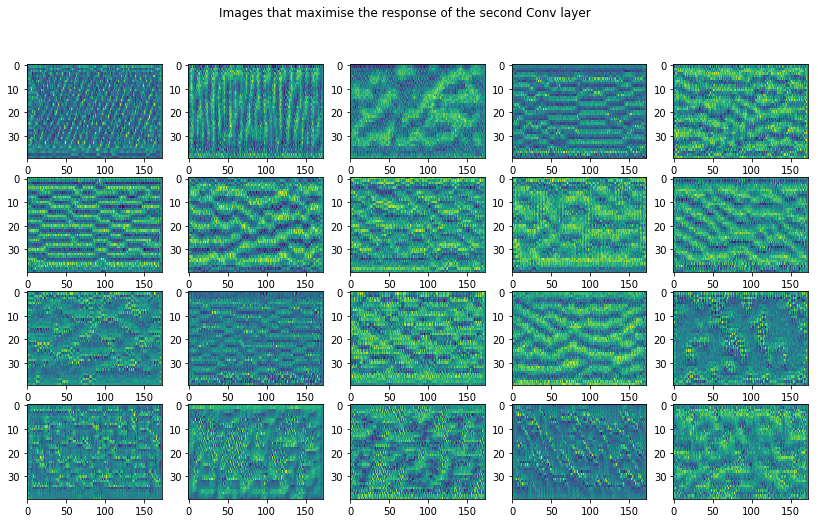

In [12]:
fig = plt.figure()
plt.suptitle('Images that maximise the response of the second Conv layer')
for idx, im in enumerate(gen_im_conv2d_2):
    plt.subplot(4,5,idx+1)
    plt.imshow(im[0,:,:,0].T, aspect='auto')

In [13]:
# choose the layer to visualise
layer_name = 'conv2d_3'

In [14]:
# choose which filters to visualise
filter_index = range(10,30)

gen_im_conv2d_3=[]

# define the output to be maximalised
layer_output = layer_dict[layer_name].output

for f in filter_index:
    # define a cost function to maximise 
    cost = K.mean(layer_output[:, :, :, f],)
    
    grads = 0
    # compute the gradient of the input picture wrt this cost
    grads = K.gradients(cost, input_data)[0]

    # normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # this function returns the cost and grads given the input matrix
    iterate = K.function([input_data], [cost, grads])
    
    input_data_gen = np.random.random((1, n_frames, n_features, 1))
    for i in range(10):
        loss_value, grads_value = iterate([input_data_gen])
        input_data_gen += grads_value 
        
        if loss_value <= 0.:
           # some filters get stuck to 0, we can skip them
            break
    gen_im_conv2d_3.append(input_data_gen)

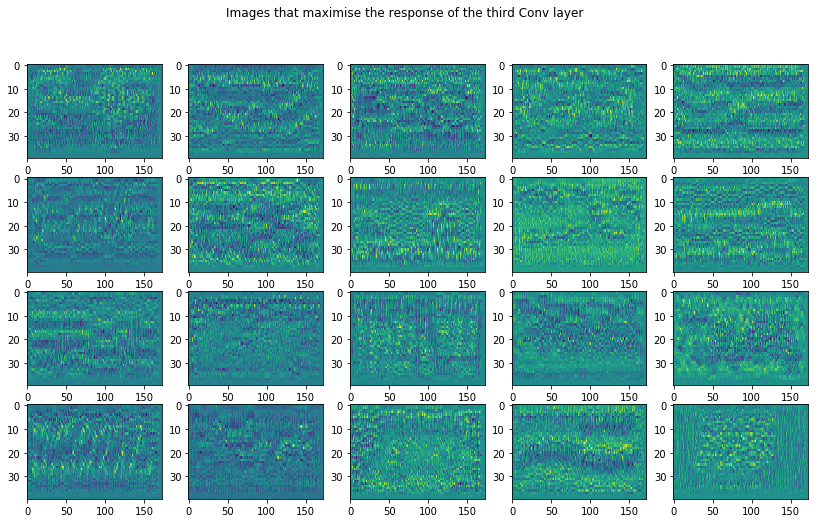

In [15]:
fig = plt.figure()
plt.suptitle('Images that maximise the response of the third Conv layer')
for idx, im in enumerate(gen_im_conv2d_3):    
    plt.subplot(4,5,idx+1)
    plt.imshow(im[0,:,:,0].T, aspect='auto')


#### How do the filters look like?

+ Let's plot the filters itself

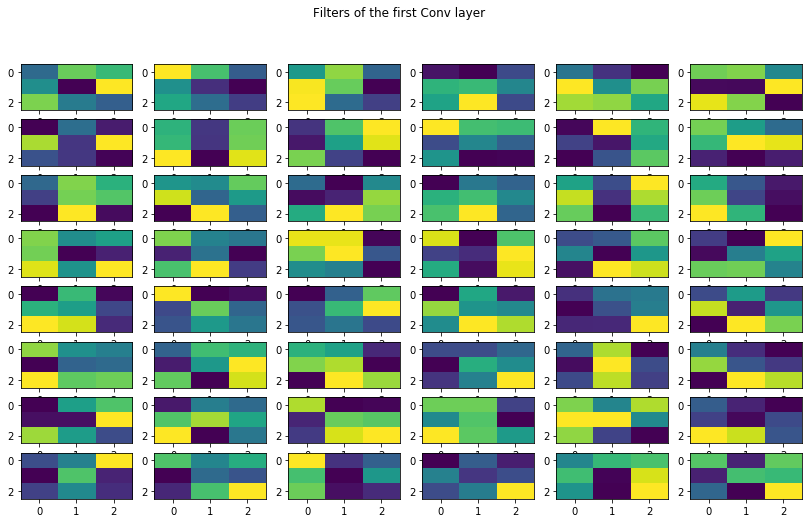

In [16]:
#choose the first Conv layer
filters=model.get_weights()[0]
fig=plt.figure()
plt.suptitle("Filters of the first Conv layer")
for idx in range(0,filters.shape[3]):
    plt.subplot(8,6,idx+1)
    im = plt.imshow(filters[:,:,0,idx], aspect='auto')

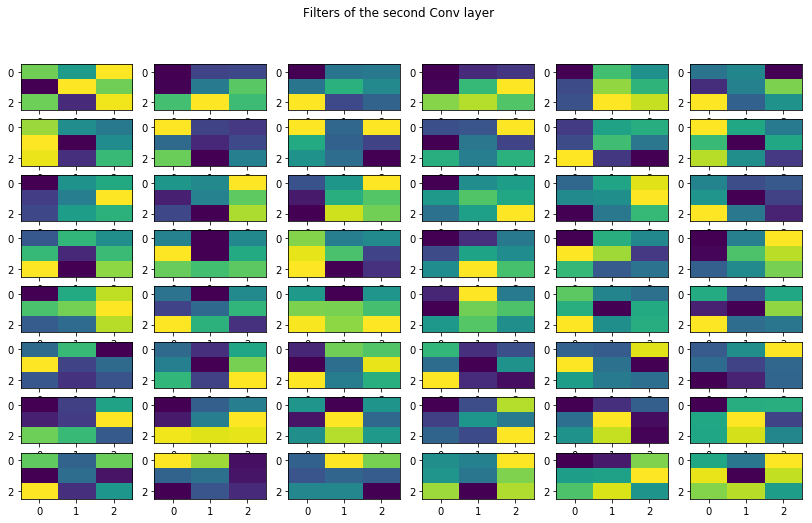

In [17]:
#choose the second Conv layer
filters=model.get_weights()[6]
fig=plt.figure()
plt.suptitle("Filters of the second Conv layer")
for idx in range(0,filters.shape[3]):
    plt.subplot(8,6,idx+1)
    im = plt.imshow(filters[:,:,0,idx], aspect='auto')

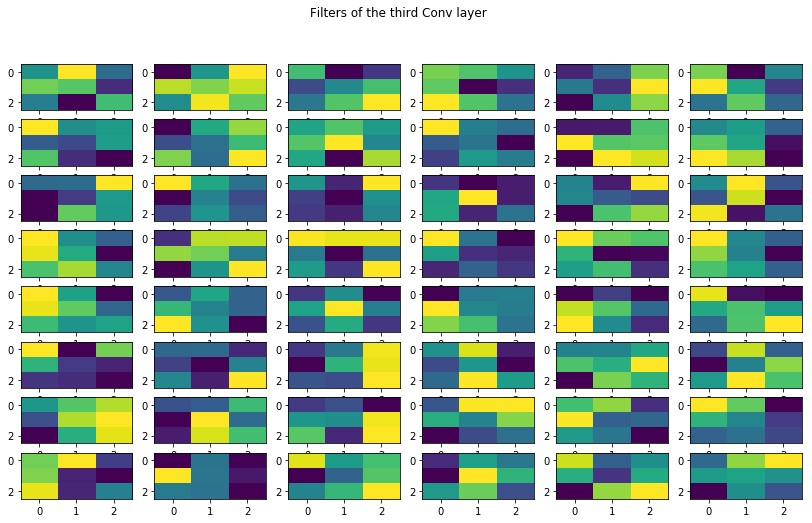

In [18]:
#choose the third Conv layer
filters=model.get_weights()[12]
fig=plt.figure()
plt.suptitle("Filters of the third Conv layer")
for idx in range(0,filters.shape[3]):
    plt.subplot(8,6,idx+1)
    im = plt.imshow(filters[:,:,0,idx], aspect='auto')

#### How does a perfect siren look like according to our model?

+ Let's maximise the output of each class 

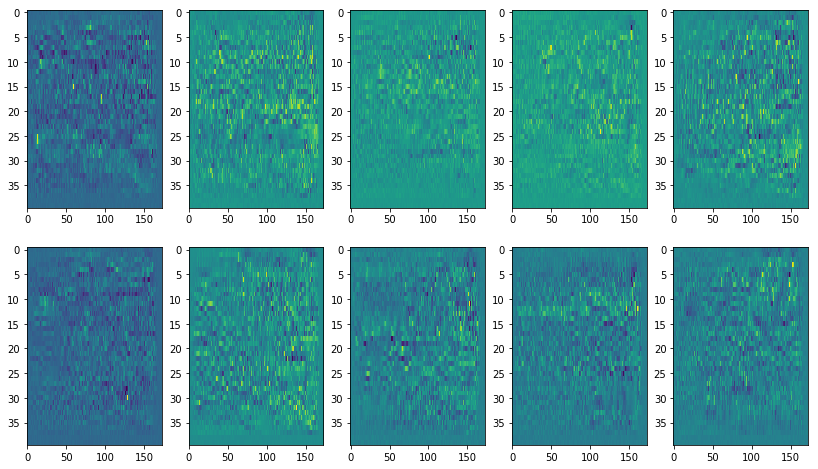

In [19]:
max_output=[]

for out in range(0,10):
    # define a cost function to maximise 
    cost = K.mean(model.output[:,out])
    
    grads = 0
    # compute the gradient of the input picture wrt this cost
    grads = K.gradients(cost, input_data)[0]

    # normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    # this function returns the cost and grads given the input picture
    iterate = K.function([input_data], [cost, grads])
    
    input_data_gen = np.random.random((1, n_frames, n_features, 1))
    for i in range(100):
        loss_value, grads_value = iterate([input_data_gen])
        input_data_gen_tmp = input_data_gen +grads_value
        input_data_gen = input_data_gen_tmp
        if loss_value <= 0:
           # some filters get stuck to 0, we can skip them
            break
    max_output.append(input_data_gen)

fig = plt.figure()
for idx, im in enumerate(max_output):
    plt.subplot(2,5,idx+1)
    plt.imshow(im[0,:,:,0].T, aspect='auto')

In [20]:
prediction = model.predict(np.squeeze(np.array(max_output),axis=1), batch_size=10, verbose=1)
print(prediction)
print(prediction.argmax(axis=0))

10/10 [==============================] - 1s 84ms/step
[[9.99e-01 1.40e-04 9.42e-05 2.96e-05 1.61e-04 1.19e-04 1.26e-05 4.59e-05
  5.24e-05 4.59e-04]
 [1.18e-05 1.00e+00 3.30e-05 2.27e-05 1.78e-05 3.49e-07 1.07e-06 1.93e-06
  1.87e-04 1.54e-04]
 [1.26e-06 5.75e-06 1.00e+00 5.66e-06 1.13e-05 1.69e-06 7.87e-08 4.31e-07
  1.34e-06 5.18e-05]
 [1.65e-06 8.65e-06 4.75e-05 1.00e+00 6.50e-05 2.07e-06 3.70e-05 1.70e-06
  2.75e-05 6.51e-05]
 [6.38e-06 8.16e-07 1.27e-05 8.89e-05 1.00e+00 1.18e-04 1.51e-05 2.38e-05
  4.19e-07 8.47e-06]
 [2.46e-05 2.08e-06 3.40e-05 8.53e-06 2.02e-05 1.00e+00 1.10e-05 2.16e-05
  1.34e-05 5.88e-06]
 [2.21e-03 5.39e-03 4.87e-01 1.46e-01 1.14e-02 8.43e-03 1.58e-01 5.25e-02
  5.02e-02 7.95e-02]
 [2.58e-05 7.08e-05 2.21e-06 1.70e-06 1.38e-04 2.34e-05 6.91e-06 1.00e+00
  6.36e-06 3.49e-05]
 [1.62e-05 6.31e-05 5.61e-05 2.08e-04 2.08e-06 5.71e-06 1.26e-05 1.80e-06
  1.00e+00 7.45e-05]
 [4.69e-07 4.75e-07 3.45e-06 2.91e-07 8.15e-07 1.38e-07 7.28e-09 7.52e-08
  4.35e-08 1.00e+

#### And how can we make our model more confident?

+ Let's maximise the output of each class given a sample input

In [21]:
scaler_path = os.path.join(workspace,'scaler.pkl')
scaler = pickle.load(open(scaler_path, 'rb'), encoding='latin1')

X_test_scaled = [scaler.transform(x.T) for x in X_test]
X_test = np.expand_dims(X_test_scaled, 3)

In [160]:
test_idx = 22
class_idx = np.argmax(y_test[test_idx])

loss = K.mean(model.output[:, class_idx])

grads_history=[]
grads = 0
# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_data)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
iterate = K.function([input_data], [loss, grads])

input_spec = X_test[test_idx]
input_data_gen = np.expand_dims(input_spec, 0)
for i in range(5):
    loss_value, grads_value = iterate([input_data_gen])
    grads_history.append(grads_value)
    input_data_gen_tmp = input_data_gen + grads_value
    input_data_gen = input_data_gen_tmp
    print('Current loss value:', loss_value)
    if loss_value <= 0:
       # some filters get stuck to 0, we can skip them
        break

Current loss value: 0.86185277
Current loss value: 0.29147553
Current loss value: 0.45068792
Current loss value: 0.86767244
Current loss value: 0.9210971


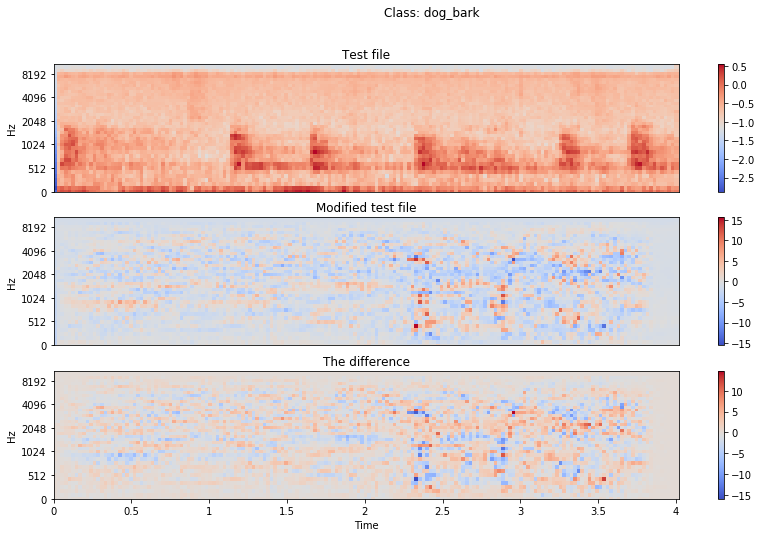

In [161]:
f=plt.figure()
fig.tight_layout()
plt.suptitle("Class: " + label_list[class_idx].decode('UTF-8'))
plt.subplot(3,1,1)
librosa.display.specshow(np.squeeze(input_spec).T,  y_axis='mel')
plt.title("Test file")
plt.colorbar()
plt.subplot(3,1,2)
librosa.display.specshow(input_data_gen[0,:,:,0].T,  y_axis='mel')
plt.colorbar()
plt.title("Modified test file")
plt.subplot(3,1,3)
librosa.display.specshow(np.subtract(np.squeeze(input_spec).T, input_data_gen[0,:,:,0].T), x_axis='time', y_axis='mel')
plt.title("The difference")
plt.colorbar()

In [162]:
prediction = model.predict(np.expand_dims(input_spec,0), batch_size=1, verbose=1)
print(prediction)
print("Predicted class on a test spectrogram: {:d}".format(np.argmax(prediction)))

predictionASCENT = model.predict(input_data_gen, batch_size=1, verbose=1)
print(predictionASCENT)
print("Predicted class on a modified spectrogram: {:d}".format(np.argmax(predictionASCENT)))

print("The actual class is: {:d}".format(class_idx))

1/1 [==============================] - 0s 16ms/step
[[6.99e-05 4.61e-05 1.16e-02 9.73e-01 8.57e-03 6.26e-04 1.17e-04 2.98e-05
  2.41e-03 3.48e-03]]
Predicted class on a test spectrogram: 3
1/1 [==============================] - 0s 15ms/step
[[3.31e-04 9.20e-04 8.67e-03 9.76e-01 7.67e-05 1.48e-04 6.36e-03 4.20e-04
  5.03e-03 1.57e-03]]
Predicted class on a modified spectrogram: 3
The actual class is: 3


#### Which parts of the input were most important for the decision? 

+ let's detect the salient parts of the spectrogram
+ first introduced in : [*Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps*](https://arxiv.org/pdf/1312.6034v2.pdf)

Suppose that all the training images of bird class contains a tree with leaves. How do we know whether the CNN is using bird-related pixels, as opposed to some other features such as the tree or leaves in the image? This actually happens more often than you think and you should be especially suspicious if you have a small training set.

The idea is pretty simple. We compute the gradient of output category with respect to input image. This should tell us how output category value changes with respect to a small change in input image pixels. All the positive values in the gradients tell us that a small change to that pixel will increase the output value. Hence, visualizing these gradients, which are the same shape as the image should provide some intuition of attention.

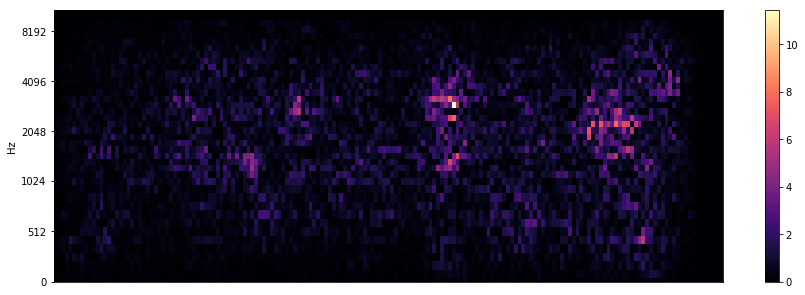

In [163]:
first_grad = grads_history[0]

f=plt.figure(figsize=(15,5))
librosa.display.specshow(np.squeeze(np.abs(first_grad)).T,  y_axis='mel')
plt.colorbar()

#### Which regions of the input were most important for the decision?

+ Let's have a look at the last convolutional layer
+ [grad-CAM](https://arxiv.org/pdf/1610.02391.pdf)


In [164]:
# choose the layer to visualise
layer_name = 'conv2d_3'

layer_output = layer_dict[layer_name].output

